#BERT 5 labels

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 4.3 MB/s 
     |████████████████████████████████| 6.8 MB 26.1 MB/s 
     |████████████████████████████████| 67 kB 5.2 MB/s 
     |████████████████████████████████| 596 kB 54.7 MB/s 
     |████████████████████████████████| 895 kB 52.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import torch
from torch.utils.data import (TensorDataset, DataLoader,
                              RandomSampler, SequentialSampler)

from transformers import BertTokenizer, BertConfig, RobertaTokenizerFast
from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

from distutils.version import LooseVersion as LV

from sklearn.model_selection import train_test_split

import io

import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    devicename = '['+torch.cuda.get_device_name(0)+']'
else:
    device = torch.device('cpu')
    devicename = ""
    
print('Using PyTorch version:', torch.__version__,
      'Device:', device, devicename)
assert(LV(torch.__version__) >= LV("1.0.0"))

Using PyTorch version: 1.10.0+cu111 Device: cuda [Tesla K80]


## loading a dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Corona_NLP_train.csv', encoding='latin1')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Corona_NLP_test.csv', encoding='latin1')

In [ ]:
df['Location'].isnull().values.any()

True

In [ ]:
df_test['Location'].isnull().values.any()

True

In [ ]:
df.dropna(subset = ["Location"], inplace=True)

In [ ]:
df_test.dropna(subset = ["Location"], inplace=True)

In [ ]:
df = df.reset_index()
df = df.drop(['index'], axis = 1)

In [ ]:
df_test = df_test.reset_index()
df_test = df_test.drop(['index'], axis = 1)

In [ ]:
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive
4,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive
...,...,...,...,...,...,...
32562,44946,89898,"Brooklyn, NY",14-04-2020,YÂall really shitting that much more at home?...,Negative
32563,44948,89900,"Toronto, Ontario",14-04-2020,Still shocked by the number of #Toronto superm...,Negative
32564,44949,89901,OHIO,14-04-2020,I never that weÂd be in a situation &amp; wor...,Positive
32565,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral


In [ ]:
df_test

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
3,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
4,6,44958,Los Angeles,03-03-2020,Do you remember the last time you paid $2.99 a...,Neutral
...,...,...,...,...,...,...
2959,3793,48745,Washington D.C.,16-03-2020,"@RicePolitics @MDCounties Craig, will you call...",Negative
2960,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
2961,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
2962,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral


In [ ]:
x_train = df['OriginalTweet']

In [ ]:
y_train = df['Sentiment']

In [ ]:
x_test = df_test['OriginalTweet']

In [ ]:
y_test = df_test['Sentiment']

### Trasformo le etichette in etichette numeriche

In [ ]:
import numpy as np

label_map = {label:idx for idx,label in enumerate(sorted(set(y_train)))}
print(label_map)

y_train_vect = np.asarray([label_map[label] for label in y_train])
y_test_vect = np.asarray([label_map[label] for label in y_test])

y_train_vect,y_test_vect

{'Extremely Negative': 0, 'Extremely Positive': 1, 'Negative': 2, 'Neutral': 3, 'Positive': 4}


(array([3, 4, 4, ..., 4, 3, 2]), array([0, 4, 2, ..., 2, 3, 1]))

## Pre-processing per BERT.
The tokenizer is already fit on the same dataset on which BERT has been pretrained and it is included in the BERT model.
To be properly handled by BERT we need to add the `[CLS]` token at the beginning of text.

In [ ]:
sentences_train = ["[CLS] " + s for s in x_train]
sentences_test = ["[CLS] " + s for s in x_test]
labels_train = y_train_vect
labels_test  = y_test_vect

Next we use the BERT tokenizer to convert the sentences into tokens that match the data BERT was trained on.

In [ ]:
BERTMODEL = "bert-base-uncased"

tokenizer = BertTokenizer.from_pretrained(BERTMODEL, do_lower_case=True)
tokenizer

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

PreTrainedTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [ ]:
from tqdm import tqdm

tokenized_train = [tokenizer.tokenize(s) for s in tqdm(sentences_train)]
tokenized_test  = [tokenizer.tokenize(s) for s in tqdm(sentences_test)]

100%|██████████| 2964/2964 [00:03<00:00, 817.87it/s]


In [ ]:
print ("The full tokenized first training sentence:")
print (tokenized_train[67])

The full tokenized first training sentence:
['[CLS]', 'i', 'work', 'in', 'retail', 'i', 'keep', 'stock', 'back', 'for', 'our', 'older', 'customers', 'so', 'when', 'such', 'as', 'frank', 'comes', 'in', 'store', 'for', 'his', 'bread', 'and', 'he', 'sees', 'a', 'empty', 'she', '##l', '##ve', 'i', 'say', 'dona', '##t', 'worry', 'pal', 'ia', '##ve', 'saved', 'you', '1', '.', 'same', 'as', 'pat', 'n', 'her', 'beans', '.', 'could', 'i', 'get', 'disciplined', '?', 'yes', 'do', 'i', 'care', '?', 'no', 'ia', '##ve', 'got', 'a', '?', '?', '#', 'corona', '##virus']


Now we set the maximum sequence lengths for our training and test sentences as `MAX_LEN_TRAIN` and `MAX_LEN_TEST`. The maximum length supported by the used BERT model is 512.

The token `[SEP]` is another special token required by BERT at the end of the sentence.

In [ ]:
MAX_LEN_TRAIN, MAX_LEN_TEST = 128, 512

tokenized_train = [t[:(MAX_LEN_TRAIN-1)]+['SEP'] for t in tokenized_train]
tokenized_test  = [t[:(MAX_LEN_TEST-1)]+['SEP'] for t in tokenized_test]

print ("The truncated tokenized first training sentence:")
print (tokenized_train[0])

The truncated tokenized first training sentence:
['[CLS]', '@', 'men', '##yr', '##bie', '@', 'phil', '_', 'ga', '##han', '@', 'chris', '##it', '##v', 'https', ':', '/', '/', 't', '.', 'co', '/', 'if', '##z', '##9', '##fan', '##2', '##pa', 'and', 'https', ':', '/', '/', 't', '.', 'co', '/', 'xx', '##6', '##gh', '##gf', '##z', '##cc', 'and', 'https', ':', '/', '/', 't', '.', 'co', '/', 'i', '##2', '##nl', '##zd', '##x', '##no', '##8', 'SEP']


Next we use the BERT tokenizer to convert each token into an integer index in the BERT vocabulary. We also pad any shorter sequences to `MAX_LEN_TRAIN` or `MAX_LEN_TEST` indices with trailing zeros.


In [ ]:
ids_train = [tokenizer.convert_tokens_to_ids(t) for t in tokenized_train]
ids_train = np.array([np.pad(i, (0, MAX_LEN_TRAIN-len(i)),
                             mode='constant') for i in ids_train])

ids_test = [tokenizer.convert_tokens_to_ids(t) for t in tokenized_test]
ids_test = np.array([np.pad(i, (0, MAX_LEN_TEST-len(i)),
                            mode='constant') for i in ids_test])

print ("The indices of the first training sentence:")
print (ids_train[0])

The indices of the first training sentence:
[  101  1030  2273 12541 11283  1030  6316  1035 11721  4819  1030  3782
  4183  2615 16770  1024  1013  1013  1056  1012  2522  1013  2065  2480
  2683 15143  2475  4502  1998 16770  1024  1013  1013  1056  1012  2522
  1013 22038  2575  5603 25708  2480  9468  1998 16770  1024  1013  1013
  1056  1012  2522  1013  1045  2475 20554 26494  2595  3630  2620   100
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


BERT also requires *attention masks*, with 1 for each real token in the sequences and 0 for the padding:

In [ ]:
amasks_train, amasks_test = [], []

for seq in ids_train:
  seq_mask = [float(i>0) for i in seq]
  amasks_train.append(seq_mask)

for seq in ids_test:
  seq_mask = [float(i>0) for i in seq]
  amasks_test.append(seq_mask)

We use scikit-learn's train_test_split() to use 10% of our training data as a validation set, and then convert all data into torch.tensors.

In [ ]:
(train_inputs, validation_inputs,
 train_labels, validation_labels) = train_test_split(ids_train, labels_train,
                                                     random_state=42, test_size=0.1)
 

(train_masks, validation_masks,
 _, _) = train_test_split(amasks_train, ids_train,
                          random_state=42, test_size=0.1)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks  = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks  = torch.tensor(validation_masks)
test_inputs = torch.tensor(ids_test)
test_labels = torch.tensor(labels_test)
test_masks  = torch.tensor(amasks_test)

Next we create PyTorch *DataLoader*s for all data sets.

For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

In [ ]:
BATCH_SIZE = 32

print('Datasets:')
print('Train: ', end="")
train_data = TensorDataset(train_inputs, train_masks,
                           train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler,
                              batch_size=BATCH_SIZE)
print(len(train_data), 'documents')

print('Validation: ', end="")
validation_data = TensorDataset(validation_inputs, validation_masks,
                                validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,
                                   sampler=validation_sampler,
                                   batch_size=BATCH_SIZE)
print(len(validation_data), 'documents')

print('Test: ', end="")
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler,
                             batch_size=BATCH_SIZE)
print(len(test_data), 'documents')

Datasets:
Train: 29310 documents
Validation: 3257 documents
Test: 2964 documents


## BERT model initialization
We now load a pretrained BERT model with a single linear classification layer added on top.

In [ ]:
model = BertForSequenceClassification.from_pretrained(BERTMODEL,
                                                      num_labels=len(label_map))
model.cuda()
print('Pretrained BERT model "{}" loaded'.format(BERTMODEL))

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Pretrained BERT model "bert-base-uncased" loaded


In [ ]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

We set the remaining hyperparameters needed for fine-tuning the pretrained model: 
 * EPOCHS: the number of training epochs in fine-tuning
   (recommended values between 2 and 4) 
 * WEIGHT_DECAY: weight decay for the Adam optimizer 
 * LR: learning rate for the Adam optimizer (2e-5 to 5e-5 recommended) 
 * WARMUP_STEPS: number of warmup steps to (linearly) reach the set learning rate

We also need to grab the training parameters from the pretrained model.

In [ ]:
EPOCHS = 4
WEIGHT_DECAY = 0.01
LR = 2e-5
WARMUP_STEPS =int(0.2*len(train_dataloader))

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters()
                if not any(nd in n for nd in no_decay)],
     'weight_decay': WEIGHT_DECAY},
    {'params': [p for n, p in model.named_parameters()
                if any(nd in n for nd in no_decay)],
     'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=LR, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS,
                                 num_training_steps =len(train_dataloader)*EPOCHS)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


### Training

Let's now define functions to train() and evaluate() the model.

In the evaluate function we compute other metrics on the predictions.

In [ ]:
def train(epoch, loss_vector=None, log_interval=200):
  # Set model to training mode
  model.train()

  # Loop over each batch from the training set
  for step, batch in enumerate(train_dataloader):

    # Copy data to GPU if needed
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Zero gradient buffers
    optimizer.zero_grad()

    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None,
                    attention_mask=b_input_mask, labels=b_labels)

    loss = outputs[0]
    if loss_vector is not None:
        loss_vector.append(loss.item())

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()
    scheduler.step()

    if step % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, step * len(b_input_ids),
                len(train_dataloader.dataset),
                100. * step / len(train_dataloader), loss))

from sklearn.metrics import confusion_matrix, classification_report

def evaluate(loader):
  model.eval()

  n_correct, n_all = 0, 0

  predicted_labels = list()
  true_labels = list()

  for batch in loader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)
      logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    predictions = np.argmax(logits, axis=1)

    labels = b_labels.to('cpu').numpy()
    n_correct += np.sum(predictions == labels)

    true_labels.extend(labels)
    predicted_labels.extend(predictions)
    n_all += len(labels)

  print('Accuracy: [{}/{}] {:.4f}'.format(n_correct, n_all,
                                          n_correct/n_all))
  print('Classification report:')
  print(classification_report(true_labels, predicted_labels,target_names=[x[0] for x in sorted(label_map.items(),key=lambda x:x[1])]))
  print('Confusion matrix:')
  cm = confusion_matrix(true_labels, predicted_labels)
  print(cm)

Now we are ready to train our model using the train() function. After each epoch, we evaluate the model using the validation set and evaluate().

In [ ]:
train_lossv = []
for epoch in range(1, EPOCHS + 1):
    print()
    train(epoch, train_lossv)
    print('\nValidation set:')
    evaluate(validation_dataloader)


Train Epoch: 1 [0/29310 (0%)]	Loss: 1.645722
Train Epoch: 1 [6400/29310 (22%)]	Loss: 1.499421
Train Epoch: 1 [12800/29310 (44%)]	Loss: 1.005393
Train Epoch: 1 [19200/29310 (66%)]	Loss: 0.738554
Train Epoch: 1 [25600/29310 (87%)]	Loss: 0.646183

Validation set:
Accuracy: [2428/3257] 0.7455
Classification report:
                    precision    recall  f1-score   support

Extremely Negative       0.63      0.91      0.74       416
Extremely Positive       0.83      0.76      0.79       523
          Negative       0.69      0.62      0.65       770
           Neutral       0.87      0.78      0.82       618
          Positive       0.75      0.75      0.75       930

          accuracy                           0.75      3257
         macro avg       0.75      0.76      0.75      3257
      weighted avg       0.75      0.75      0.75      3257

Confusion matrix:
[[378   1  35   0   2]
 [  2 399   5   3 114]
 [211   5 475  21  58]
 [  2   2  75 479  60]
 [ 11  75 101  46 697]]

Train Ep

Let's take a look at our training loss over all batches:


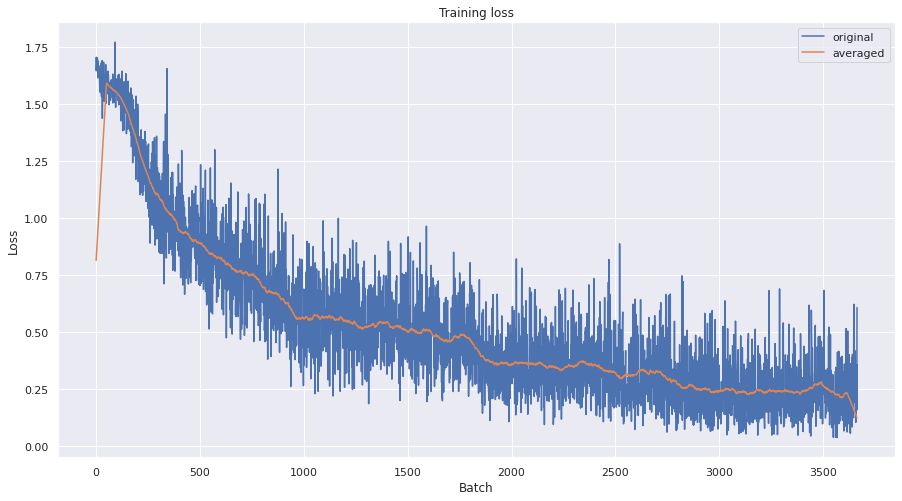

In [ ]:
%matplotlib inline
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_lossv, label='original')
plt.plot(np.convolve(train_lossv, np.ones(101), 'same') / 101,
         label='averaged')
plt.legend(loc='best')
plt.show()

### Evaluation

For a better measure of the quality of the model, let's see the model accuracy for the test reviews.

In [ ]:
print('Test set:')
evaluate(test_dataloader)

Test set:
Accuracy: [2450/2964] 0.8266
Classification report:
                    precision    recall  f1-score   support

Extremely Negative       0.77      0.90      0.83       449
Extremely Positive       0.86      0.88      0.87       482
          Negative       0.81      0.77      0.79       811
           Neutral       0.94      0.84      0.88       497
          Positive       0.80      0.80      0.80       725

          accuracy                           0.83      2964
         macro avg       0.83      0.84      0.83      2964
      weighted avg       0.83      0.83      0.83      2964

Confusion matrix:
[[402   0  46   1   0]
 [  0 424   2   0  56]
 [110   3 626  17  55]
 [  1   1  43 415  37]
 [  6  67  60   9 583]]
